# Treinamento QAM Rayleigh

### Algoritmo considerando desvanecimento lento e codificação convolucional

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import tensorflow as tf
import os
import sys
sys.path.append('../..')

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from libs.commpy_mod import SISOFlatChannel

from Files_aux.files_01_detection.const_mod import generate_symbols, Model
from Files_aux.files_01_detection.const_analyzer import plot_decision_boundary, theoretical_error, ser, plot_confusion_matrix, plot_symbols
 
%matplotlib inline

2023-10-23 14:51:54.652177: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 14:51:54.749865: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-23 14:51:54.751609: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 14:51:56.379942: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
total_num_symbols  = 100    # Number of transmitted symbols to be used for training and test
train_fraction = 0.4 # Fraction of whole data to be used for training (the remaining is for testing)
code_rate    = 1/2       # Rate of the used code
Es           = 1       # Average symbol energy
Mod = 'QAM'
channel_type = 'awgn' # 'awgn' or 'crazy'
M            = [4, 16]      # QAM modulation
vel_alph     = 20

In [3]:
from libs.Gerador import Train_Data

x_out, alph, y_out, symbs, bits = Train_Data(Mod, total_num_symbols, M[0], channel_type, Es, code_rate, 50,51)

True
100
100


In [37]:
import commpy.modulation as cm
modem = cm.QAMModem(M[0])
c = modem.constellation

In [5]:
c

array([-1.-1.j, -1.+1.j,  1.-1.j,  1.+1.j])

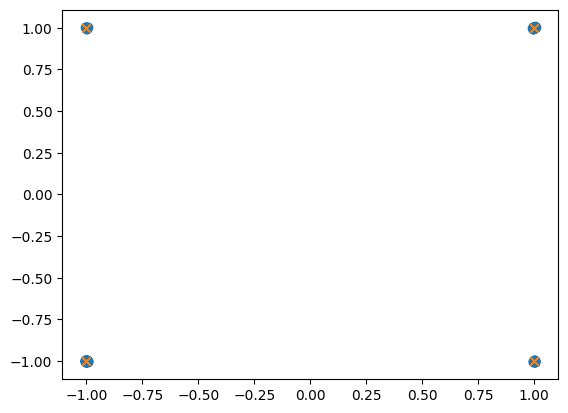

In [67]:
plt.plot(x_out[::2],x_out[1::2], 'o')
plt.plot(np.real(symbs).reshape(-1),np.imag(symbs).reshape(-1), 'x')

In [46]:
alph

array([1., 1., 1., 1., 1.])

In [53]:
un_modulate

array([-0.99949257+1.00018944j,  0.99695046+1.00030254j,
       -0.99869044+1.00112932j,  1.00092033+1.00146944j,
        1.00152874-1.00139873j, -0.99832828+0.99854435j,
        0.99947576+0.99764834j,  0.99797107+0.9990449j ,
       -0.99841515-1.00609781j,  1.0007046 +0.99538058j,
       -0.99765927-0.99700758j, -0.99752257+1.00238385j,
        1.00070206+0.99914737j,  0.99637911+1.002775j  ,
        1.00194712-0.99634152j,  1.00318957-1.00212634j,
       -0.99946634+0.998302j  ,  0.99976013+0.99975105j,
        1.0017093 +1.00317755j, -0.99866763+1.00205277j,
        0.9999083 +1.00165069j,  0.99977366-0.99993875j,
       -0.9965676 +0.99931671j, -0.99987652-0.99922637j,
       -0.99926172-0.99731755j,  0.99906689+0.99762591j,
       -1.00126959+1.00002904j,  1.00323181-0.9994383j ,
       -0.99840672-0.9960143j ,  0.99968391-1.00132376j,
        0.99704127-1.00001454j,  1.00098072+0.99584295j,
       -0.99981476+0.99934882j, -1.00444374+1.00097982j,
       -0.99808182-0.99923042j,

In [58]:
a = []
for i in range(len(alph)):
    a.append(un_modulate[i*vel_alph:i*vel_alph+vel_alph])
a = np.array(a).reshape(-1)

In [59]:
a

array([-0.99949257+1.00018944j,  0.99695046+1.00030254j,
       -0.99869044+1.00112932j,  1.00092033+1.00146944j,
        1.00152874-1.00139873j, -0.99832828+0.99854435j,
        0.99947576+0.99764834j,  0.99797107+0.9990449j ,
       -0.99841515-1.00609781j,  1.0007046 +0.99538058j,
       -0.99765927-0.99700758j, -0.99752257+1.00238385j,
        1.00070206+0.99914737j,  0.99637911+1.002775j  ,
        1.00194712-0.99634152j,  1.00318957-1.00212634j,
       -0.99946634+0.998302j  ,  0.99976013+0.99975105j,
        1.0017093 +1.00317755j, -0.99866763+1.00205277j,
        0.9999083 +1.00165069j,  0.99977366-0.99993875j,
       -0.9965676 +0.99931671j, -0.99987652-0.99922637j,
       -0.99926172-0.99731755j,  0.99906689+0.99762591j,
       -1.00126959+1.00002904j,  1.00323181-0.9994383j ,
       -0.99840672-0.9960143j ,  0.99968391-1.00132376j,
        0.99704127-1.00001454j,  1.00098072+0.99584295j,
       -0.99981476+0.99934882j, -1.00444374+1.00097982j,
       -0.99808182-0.99923042j,

In [4]:
def bits_to_num(arrayBits, lenBits):
    matriz_conversao = np.array([2**i for i in range(lenBits - 1, -1, -1)])
    arrayBits = arrayBits.reshape((-1, bits_per_symbol))
    return arrayBits.dot(matriz_conversao)

def decod_sinal(x_cod, alph, M, vel_alph, Mod): 
    x = x_cod.reshape((-1,2))
    un_modulate = x[:,0] + 1j * x[:,1]
    a = []
    for i in range(len(alph)):
        a.append(un_modulate[i*vel_alph:i*vel_alph+vel_alph] / alph[i])
    a = np.array(a).reshape(-1)

    #Treliça
    bits_per_symbol = int(np.log2(M))
    constraint_length = np.array(3, ndmin=1)  # Comprimento de restrição do código (3 neste exemplo)
    code_generator = np.array([[5, 7]])  # Polinômio gerador em octal
    m = np.array([bits_per_symbol-1]) # Número de elementos de delay

    import commpy.modulation as modulation
    import commpy.channelcoding.convcode as cc

    # Criando o objeto do código convolucional
    trellis = cc.Trellis(memory=constraint_length, g_matrix=code_generator)

    modem = modulation.QAMModem(M) if Mod == "QAM" else modulation.PSKModem(M)
    demod = modem.demodulate(a, demod_type='hard')

    return cc.viterbi_decode(demod, trellis, decoding_type='hard'), demod

In [5]:
decoded, demod = decod_sinal(x_out, alph, M[0], vel_alph, Mod)
bits_per_symbol = int(np.log2(M[0]))

In [6]:
len(decoded)

200

In [7]:
bits = np.array(bits).reshape(-1)

In [8]:
len(bits)

200

In [9]:
decoded

array([1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0])

In [10]:
bits

array([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1], dtype=int8)

In [35]:
x = x_out.reshape((-1,2))
un_modulate = x[:,0] + 1j * x[:,1]

In [40]:
modem.modulate(bits)

array([-1.+1.j,  1.+1.j, -1.+1.j,  1.+1.j,  1.-1.j, -1.+1.j,  1.+1.j,
        1.+1.j, -1.-1.j,  1.+1.j, -1.-1.j, -1.+1.j,  1.+1.j,  1.+1.j,
        1.-1.j,  1.-1.j, -1.+1.j,  1.+1.j,  1.+1.j, -1.+1.j,  1.+1.j,
        1.-1.j, -1.+1.j, -1.-1.j, -1.-1.j,  1.+1.j, -1.+1.j,  1.-1.j,
       -1.-1.j,  1.-1.j,  1.-1.j,  1.+1.j, -1.+1.j, -1.+1.j, -1.-1.j,
        1.-1.j, -1.+1.j, -1.+1.j, -1.-1.j,  1.-1.j, -1.-1.j,  1.-1.j,
        1.+1.j, -1.-1.j, -1.+1.j, -1.+1.j,  1.-1.j, -1.+1.j,  1.+1.j,
        1.+1.j, -1.-1.j,  1.+1.j, -1.+1.j, -1.+1.j,  1.+1.j, -1.+1.j,
       -1.-1.j, -1.-1.j, -1.+1.j,  1.-1.j, -1.-1.j, -1.-1.j,  1.-1.j,
        1.-1.j, -1.-1.j, -1.+1.j, -1.-1.j,  1.-1.j,  1.-1.j, -1.-1.j,
        1.+1.j, -1.-1.j,  1.-1.j,  1.+1.j, -1.-1.j,  1.+1.j, -1.+1.j,
       -1.+1.j,  1.-1.j,  1.-1.j,  1.-1.j, -1.+1.j,  1.+1.j, -1.+1.j,
        1.+1.j, -1.+1.j, -1.-1.j, -1.+1.j, -1.+1.j, -1.-1.j, -1.+1.j,
        1.-1.j, -1.-1.j, -1.-1.j, -1.+1.j,  1.-1.j, -1.+1.j,  1.+1.j,
        1.+1.j,  1.-

In [41]:
modem.demodulate(un_modulate[-1], demod_type='hard')

array([1, 0], dtype=int8)

In [49]:
bits

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0], dtype=int8)

In [51]:
z

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0], dtype=int8)

In [52]:
(z+1 == bits+1).sum()/len(bits)

1.0

In [50]:
z = modem.demodulate(un_modulate, demod_type='hard')

In [25]:
len(y_out)

100

In [70]:
(bits_to_num(decoded, bits_per_symbol) + 1 == y_out + 1).sum()/total_num_symbols

0.44

In [17]:
(bits == demod).sum()/len(bits)

0.585

In [28]:
bits = np.array(bits).reshape(-1)

In [63]:
(bits_to_num(bits, bits_per_symbol)+1 == bits_to_num(demod, bits_per_symbol)+1).sum()/total_num_symbols

0.99

In [44]:
demod

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 0], dtype=int8)

In [45]:
bits

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0], dtype=int8)

In [64]:
(bits_to_num(bits, bits_per_symbol) == bits_to_num(demod, bits_per_symbol)+1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False])

In [9]:
decoded

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0])

In [15]:
bits_to_num(decoded, bits_per_symbol)

array([0, 3, 2, 2, 2, 0, 0, 3, 3, 2, 3, 0, 0, 2, 1, 1, 0, 1, 0, 1, 2, 0,
       1, 0, 2, 2, 0, 2, 0, 3, 0, 0, 2, 1, 1, 0, 1, 0, 3, 2, 2, 0, 1, 0,
       0, 3, 3, 2, 0, 2, 0, 2, 1, 1, 0, 1, 0, 3, 0, 0, 1, 0, 2, 2, 0, 2,
       0, 3, 3, 0, 2, 1, 1, 0, 1, 0, 1, 3, 2, 1, 0, 2, 2, 0, 2, 1, 2, 0,
       1, 2, 1, 1, 0, 1, 0, 3, 0, 0, 3, 0])

In [16]:
y_out

array([0., 3., 3., 1., 1., 2., 0., 3., 2., 3., 3., 2., 1., 3., 2., 0., 3.,
       1., 1., 0., 1., 3., 2., 3., 0., 3., 2., 1., 2., 2., 2., 2., 3., 0.,
       1., 0., 3., 0., 0., 2., 3., 1., 2., 3., 0., 1., 2., 3., 1., 2., 1.,
       3., 0., 3., 2., 3., 3., 3., 3., 1., 1., 3., 0., 1., 0., 2., 2., 0.,
       3., 0., 0., 0., 3., 2., 2., 3., 0., 1., 0., 1., 3., 0., 0., 0., 0.,
       2., 1., 2., 2., 3., 2., 0., 3., 3., 3., 3., 3., 0., 3., 3.])

In [46]:
demod

array([0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 0], dtype=int8)

In [3]:
def error(amostras, model, mod, M, channel_type, Es, code_rate, snr):
    frac = 10000
    if os.path.exists(f'bit_error/{channel_type}/rede-{model[1]}-{M}-{mod}-{snr[0]}-SNR.dat'):
        error = np.fromfile(f'bit_error/{channel_type}/rede-{model[1]}-{M}-{mod}-{snr[0]}-SNR.dat', dtype=np.float64)
    else:    
        error = 0
        a = amostras
        for i in range(amostras // frac + 1):
            if a < frac:
                frac = amostras % frac
            sub_amostras =  conjunto(Mod, frac, M, channel_type, Es, code_rate, snr, False)
            error += ser(model[0], tf.reshape(tf.convert_to_tensor(sub_amostras[0]), [-1, 2]),
                              tf.reshape(tf.convert_to_tensor(sub_amostras[2]), [-1, 1]), nn=True)
            a -= frac
        error /= amostras / frac
        error.tofile(f'bit_error/{channel_type}/rede-{model[1]}-{M}-{mod}-{snr[0]}-SNR.dat')
    return error

def conjunto(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB, symb=False, scaler=None):

    symbs, indices, channel_output, channel_alph = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, [SNR_dB[0]])

    x = np.array([])
     
    x = np.append(x, np.stack([np.real(channel_output[:]),
                    np.imag(channel_output[:])], axis=1))
    x = x.reshape(-1, 2)
    if scaler is not None:
        x = scaler(x)
    
    for i in range(1, len(SNR_dB)):
        a, b, c, e = Model(Mod, total_num_symbols, M, channel_type, Es, code_rate, SNR_dB[i])
        
        d = np.array([])   
        d = np.append(d, np.stack([np.real(c[:]),
                        np.imag(c[:])], axis=1))
        d.reshape(-1, 2)
        
        if scaler is not None:
            d = scaler(d)
        
        symbs = np.vstack((symbs, a))
        indices = np.vstack((indices, b))
        channel_alph = np.vstack((channel_alph, e))
        x = np.vstack((x, d))
    
    y = np.float_(indices.reshape(-1))
        
    if symb:
        return x, channel_alph, y, symbs
    else:
        return x, channel_alph, y

In [62]:
x_out = []
alpha_out = []
y_out = []
symbs = []

#### Rede a implementar e reorganizar estrutura da convolucional (Pendente)

In [63]:
x_out.append(np.fromfile('Random_Data/Desv_Lento/Codificado/SNR_10-30/Rayleigh/16-QAM/x_rand.dat', dtype=np.dtype('float64')).reshape((-1, 2)))
alpha_out.append(np.fromfile('Random_Data/Desv_Lento/Codificado/SNR_10-30/Rayleigh/16-QAM/alph.dat', dtype=np.dtype('float64')).reshape((-1, 1)))
y_out.append(np.fromfile('Random_Data/Desv_Lento/Codificado/SNR_10-30/Rayleigh/16-QAM/y_rand.dat', dtype=np.dtype('float64')).reshape((-1, 1)))
symbs.append(np.fromfile('Random_Data/Desv_Lento/Codificado/SNR_10-30/Rayleigh/16-QAM/symb.dat', dtype=np.dtype('complex128')).reshape((1, -1)))

In [64]:
x_out.append(np.fromfile('Random_Data/Desv_Lento/Codificado/SNR_5-20/Rayleigh/4-QAM/x_rand.dat', dtype=np.dtype('float64')).reshape((-1, 2)))
alpha_out.append(np.fromfile('Random_Data/Desv_Lento/Codificado/SNR_5-20/Rayleigh/4-QAM/alph.dat', dtype=np.dtype('float64')).reshape((-1, 1)))
y_out.append(np.fromfile('Random_Data/Desv_Lento/Codificado/SNR_5-20/Rayleigh/4-QAM/y_rand.dat', dtype=np.dtype('float64')).reshape((-1, 1)))
symbs.append(np.fromfile('Random_Data/Desv_Lento/Codificado/SNR_5-20/Rayleigh/4-QAM/symb.dat', dtype=np.dtype('complex128')).reshape((1, -1)))

In [68]:
symbs[0].shape

(1, 200000)

In [52]:
# Generate dataset
# Train
train_size = int(train_fraction * total_num_symbols / vel_alph) #data used for training
X_train = []
alph_train = []
y_train = []
X_test = []
alph_test = []
y_test = []
for i in range(len(M)):
    y_train.append(y_out[i][:train_size])
    X_train.append(x_out[i][:train_size])
    alph_train.append(alpha_out[i][:train_size])

    # Test
    y_test.append(y_out[i][train_size:])
    X_test.append(x_out[i][train_size:])
    alph_train.append(alpha_out[i][train_size:])

    #scaler = StandardScaler()
    #scaler.fit(X_train[i])  # Don't cheat - fit only on training data
    #X_train[i] = scaler.transform(X_train[i])
    #X_test[i] = scaler.transform(X_test[i])


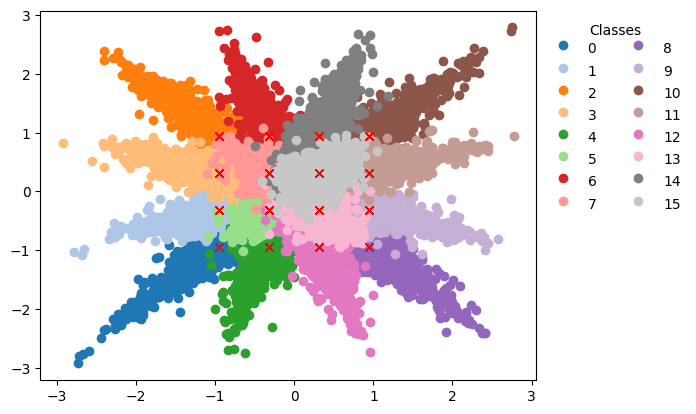

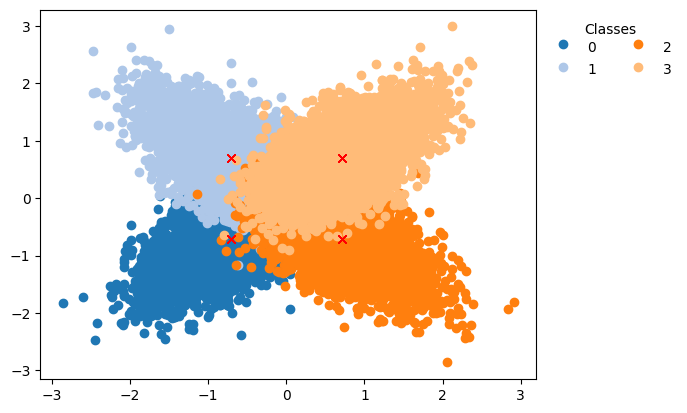

In [54]:
for i in range(len(M)):
    plot_symbols(X_train[i].reshape((-1, 2)), y_train[i].reshape(-1), M[i], symbs[i])

In [8]:
n_inputs = 3

In [9]:
n_redes = 1
n_hidden = [[300, 180, 90, 40]]

n_outputs = M
learning_rate = [0.01]
n_epochs = [50]
batch_size = [100]
momentum = [0.8]

In [56]:
y_train_tf = tf.reshape(tf.convert_to_tensor(y_train), [len(M), -1, vel_alph, 1])
y_test_tf = tf.reshape(tf.convert_to_tensor(y_test), [len(M), -1, vel_alph, 1])
X_test_tf = tf.reshape(tf.convert_to_tensor(X_test),[len(M), -1, vel_alph, 2])
X_train_tf = tf.reshape(tf.convert_to_tensor(X_train),[len(M), -1, vel_alph, 2])

In [64]:
y_train_tf = [tf.convert_to_tensor([tf.keras.utils.to_categorical(y_train_tf[i][j], M[i]) for j in range(len(y_train_tf[0]))]) for i in range(len(M))]
y_test_tf = [tf.convert_to_tensor([tf.keras.utils.to_categorical(y_test_tf[i][j], M[i]) for j in range(len(y_test_tf[0]))]) for i in range(len(M))]

### Usando API Keras

In [31]:
from keras.models import model_from_json

model_QAM = []
for i in range(len(M)):
    for j in range(n_redes):
        with open(f"Modelos/rayleigh/model-{M[i]}-Rede-{j}.json", 'r') as json_file:
            loaded_model_json = json_file.read()

        # Cria o modelo a partir do arquivo JSON
        model = model_from_json(loaded_model_json)

        # Carrega os pesos do modelo a partir do arquivo h5
        model.load_weights(f"Modelos/rayleigh/model-{M[i]}-Rede-{j}.h5")
        
        model_QAM.append(model)

model_QAM = np.array(model_QAM).reshape(len(M), -1)

In [16]:
inputs = tf.keras.Input(shape=(n_inputs, 1))
output = []

for k in range(len(M)):
    for i in range(n_redes):
        x = inputs
        x = tf.keras.layers.Conv1D(32, 2, 1, "same", activation='elu', kernel_initializer="glorot_normal")(x)
        x = tf.keras.layers.Flatten()(x)
        for j in range(len(n_hidden[i])):
            x = tf.keras.layers.Dense(n_hidden[i][j], activation="elu", kernel_initializer="glorot_normal")(x)
        output.append(tf.keras.layers.Dense(n_outputs[k], kernel_initializer="glorot_normal")(x))
        del x

In [17]:
tf.keras.Model(inputs=inputs, outputs=output[0]).summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 3, 32)             96        
                                                                 
 flatten_2 (Flatten)         (None, 96)                0         
                                                                 
 dense_10 (Dense)            (None, 300)               29100     
                                                                 
 dense_11 (Dense)            (None, 180)               54180     
                                                                 
 dense_12 (Dense)            (None, 90)                16290     
                                                                 
 dense_13 (Dense)            (None, 40)                3640

In [18]:
model_QAM = []
for k in range(len(M)):
    for i in range(n_redes):
        model_QAM.append(tf.keras.Model(inputs=inputs, outputs=output[i + 3*k]))

        model_QAM[i + 3*k].compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     optimizer=tf.keras.optimizers.experimental.SGD(learning_rate=learning_rate[i], momentum=momentum[i], nesterov=True),
                     metrics=["accuracy"])

        history = model_QAM[i + 3*k].fit(X_train_tf[k], y_train_tf[k], batch_size=batch_size[i], epochs=n_epochs[i], shuffle=True)

        tests_score = model_QAM[i + 3*k].evaluate(X_test_tf[k], y_test_tf[k])
        print("\nTest loss:", tests_score[0])
        print("Test accuracy:", tests_score[1])
        print(f"Taxa de erro simbólica de {(1 - tests_score[1]):.2%}\n")

model_QAM = np.array(model_QAM).reshape(len(M), -1)

Epoch 1/50


ValueError: in user code:

    File "/home/rketson/anaconda3/envs/DL-22/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/rketson/anaconda3/envs/DL-22/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/rketson/anaconda3/envs/DL-22/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/rketson/anaconda3/envs/DL-22/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/rketson/anaconda3/envs/DL-22/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/home/rketson/anaconda3/envs/DL-22/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/rketson/anaconda3/envs/DL-22/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/rketson/anaconda3/envs/DL-22/lib/python3.10/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/rketson/anaconda3/envs/DL-22/lib/python3.10/site-packages/keras/losses.py", line 2084, in sparse_categorical_crossentropy
        return backend.sparse_categorical_crossentropy(
    File "/home/rketson/anaconda3/envs/DL-22/lib/python3.10/site-packages/keras/backend.py", line 5630, in sparse_categorical_crossentropy
        res = tf.nn.sparse_softmax_cross_entropy_with_logits(

    ValueError: `labels.shape` must equal `logits.shape` except for the last dimension. Received: labels.shape=(1600,) and logits.shape=(100, 16)


In [35]:
for i in range(len(M)):
    for j in range(n_redes):
        model_json = model_QAM[i][j].to_json()
        with open(f"Modelos/rayleigh/model-{M[i]}-Rede-{j}.json", "w") as json_file:
            json_file.write(model_json)
        model_QAM[i][j].save_weights(f"Modelos/rayleigh/model-{M[i]}-Rede-{j}.h5")

Modelo 16-QAM:



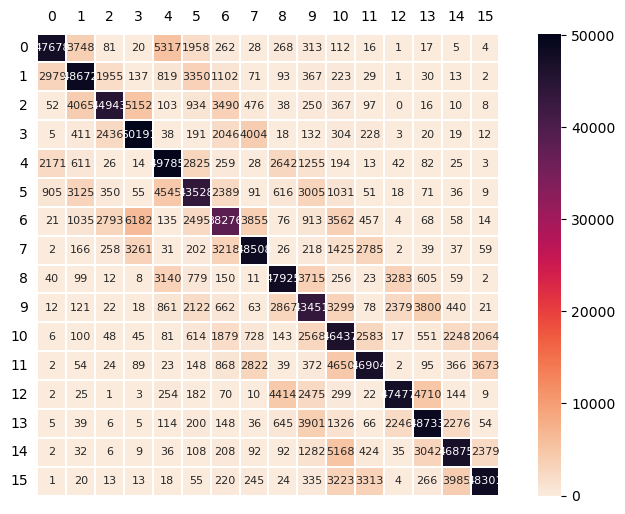

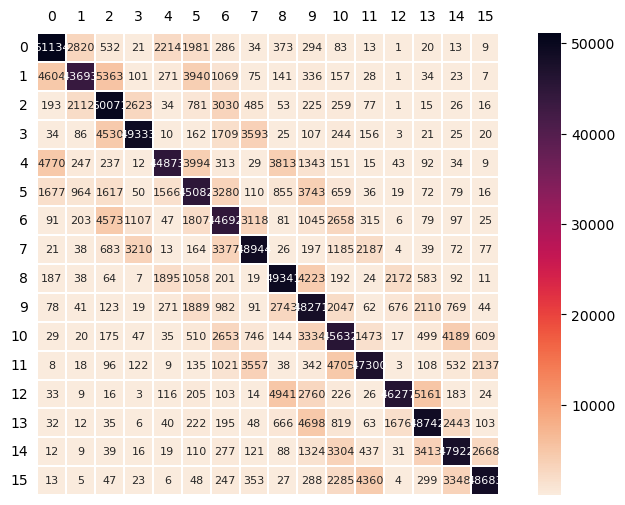

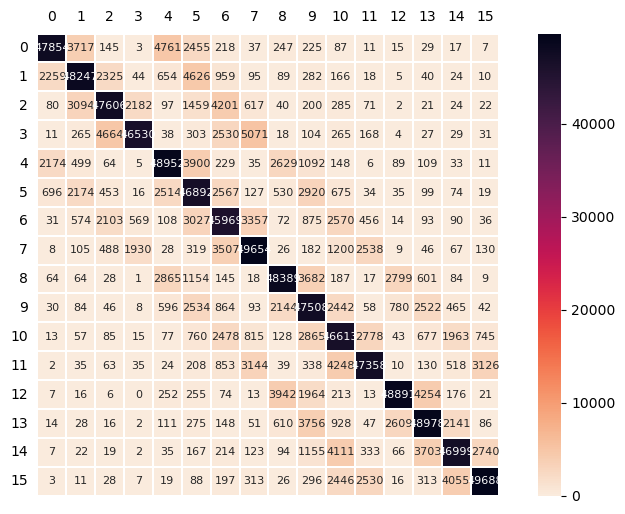

Modelo 4-QAM:



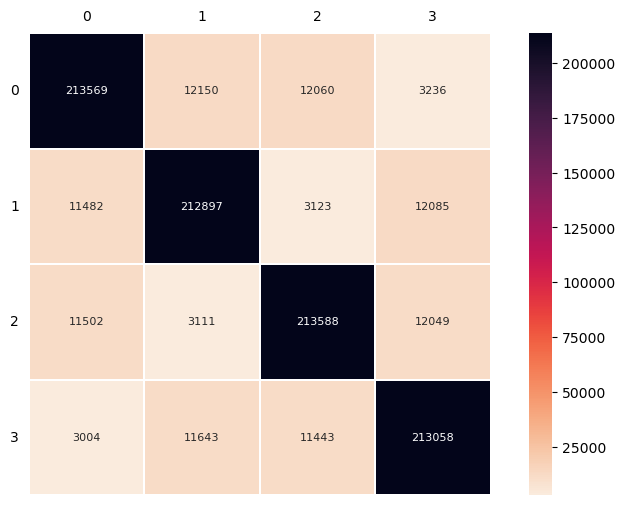

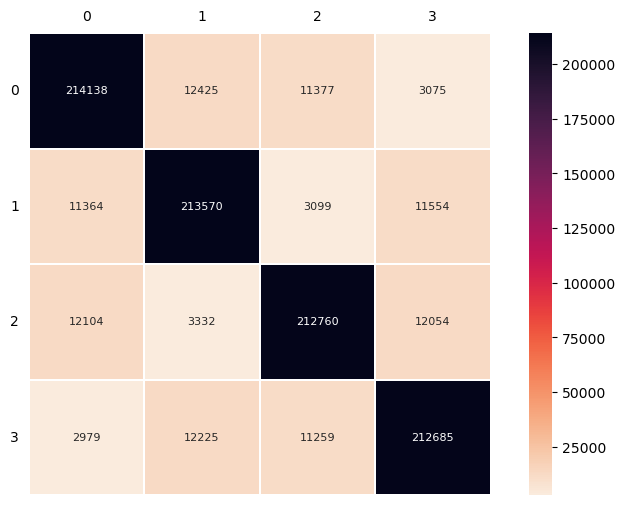

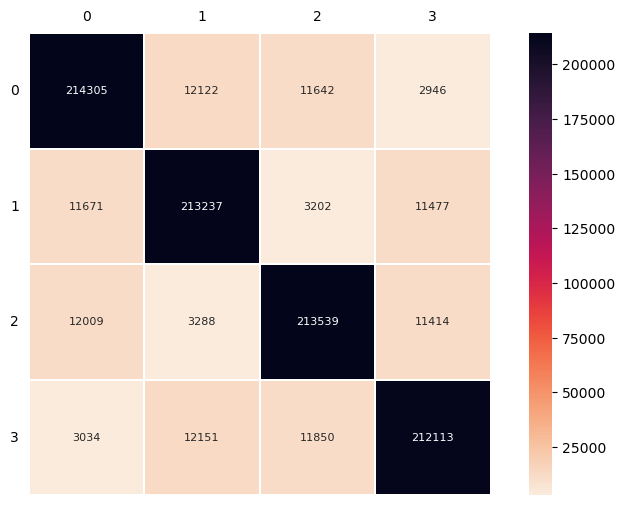

In [28]:
for i in range(len(M)):
    print(f'Modelo {M[i]}-QAM:\n')
    for j in range(n_redes):
        plot_confusion_matrix(model_QAM[i][j], X_test_tf[i], y_test_tf[i], M[i], nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True)
#plot_decision_boundary(modelK, X_train, y_train, legend=True, nn=True, plot_training=False)

## Avaliação do modelo em diferentes faixas de relação sinal/ruído

### QAM | Rayleigh

Obs: Subdividir amostras em conjuntos menores e realizar o treinamento (1000 subamostros por exemplo). Fazer a verificação de bits sem aproximação. Testar em um intervalo maior para verificar se a rede diverge em algum momento.

In [7]:
Mod = "QAM"
channel_type = "rayleigh"
init_scale = 1
interval = [90, 60]
passo = 8

In [8]:
Teo_SNRs = [[theoretical_error(Mod, M[k], init_scale + i, channel_type) for i in range(0, interval[k], passo)] for k in range(len(M))]

In [ ]:
error_rate = [([[error(int(100 / (Teo_SNRs[k][int(i / passo)] * np.log2(M[k]))), [model_QAM[k][j], j], Mod, M[k], channel_type, Es, code_rate, [init_scale + i]) for i in range(0, interval[k], passo)] for j in range(n_redes)]) / (tf.math.log(float(M[k]))/tf.math.log(2.)) for k in range(len(M))]

In [9]:
error(int(100 / (Teo_SNRs[0][int(0 / passo)] * np.log2(M[0]))), [model_QAM[0][0], 0], Mod, M[0], channel_type, Es, code_rate, [init_scale + 0])

array([-7.4629786e-36,  1.8149999e+00], dtype=float32)

### error_rate

In [14]:
np.fromfile(f'bit_error/awgn/rede-1-16-QAM-11-SNR.dat', dtype=np.float64)

array([0.18122977])

In [22]:
np.mean(error_rate - Teo_SNRs)

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [ ]:
import matplotlib.ticker as tick

for k in range(len(M)):
    y1 = Teo_SNRs[k]
    x = range(init_scale, init_scale + interval[k], passo)

    fig, ax = plt.subplots(1,1)

    ax.plot(x, y1, 'go-', label='Theoretical Curve', linewidth=2)
    [ax.plot(x, error_rate[k][i], 's--', label=f'Empirical Curve (Rede {i + 1})') for i in range(n_redes)]

    ax.set_title(f'{M[k]}-QAM - Rayleigh')
    ax.set_xlabel('SNR_dB')
    ax.set_ylabel('Taxa de erro por bit')

    def y_fmt(x, y):
        return '{:2.1e}'.format(x)

    ax.set_yscale("log")
    ax.yaxis.set_major_formatter(tick.FuncFormatter(y_fmt))
    #plt.plot(x2, y2, 'rs--',  label='line 2')

    plt.legend()
    plt.show()